## Finding Donors for *CharityML*
### Supervised Learning
<hr>

### (Kaggle/Udacity) Competition Description
CharityML is a fictitious charity organization located in the heart of Silicon Valley that was established to provide financial support for people eager to learn machine learning. After nearly 32,000 letters were sent to people in the community, CharityML determined that every donation they received came from someone that was making more than $50,000 annually. To expand their potential donor base, CharityML has decided to send letters to residents of California, but to only those most likely to donate to the charity. 
With nearly 15 million working Californians, CharityML has brought you on board to help build an algorithm to best identify potential donors and reduce overhead cost of sending mail. Your goal will be evaluate and optimize several different supervised learners to determine which algorithm will provide the highest donation yield while also reducing the total number of letters being sent. <br>
URL: https://www.kaggle.com/c/udacity-mlcharity-competition

<hr>
In this project, I will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. 

My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. 

This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The data I have investigated here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.


----
## Exploring the Data
Load necessary Python libraries and the census data. <br> <br>
Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

display(data.tail(n=4))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K
45221,35,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. <br>

In the code cell below, I have computed the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [2]:
sum(data['income'] == '>50K')

11208

In [3]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income'] == '>50K')

# Number of records where individual's income is at most $50,000
n_at_most_50k =sum(data['income'] == '<=50K')

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured. <br> Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
 '`capital-gain'` and `'capital-loss'` variables are found to be skewed and need to be normalized. <br>
 Histogram below shows distribution


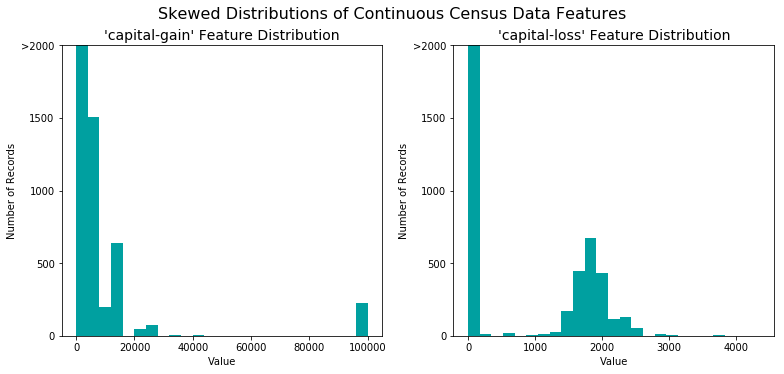

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, we shall apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. <br> Using a logarithmic transformation significantly reduces the range of values caused by outliers however care must be taken when applying this transformation however the logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.


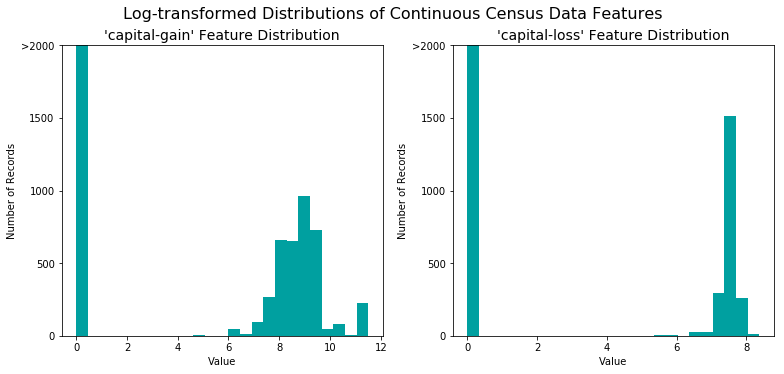

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
Performing scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. 

We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. We shall convert catagorical variables to numeric.

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we will simply encode these two categories as `0` and `1`, respectively. 

In [7]:
#income_raw

In [8]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income_map = {'<=50K': 0, '>50K': 1}
income = income_raw.map(income_map)

encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print (encoded)

103 total features after one-hot encoding.


In [9]:
income.count()

45222

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [10]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


C:\Users\maazh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, I will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners while the fourth algorithm will be a *naive predictor*.

### Naive Predictor Performace
A naive predictor is used to show what a base model without any intelligence would look like.

In [11]:
# Calculate accuracy, precision and recall
accuracy = n_greater_50k / n_records
recall = 1
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)
# print('p', precision)
# Calculate F-score using the formula for beta = 0.5 and correct values for precision and recall.
fscore = (1 + (0.5 * 0.5)) * ((precision * recall)/((0.25 *precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**List of supervised learning models currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that I need to choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application

The three supervised learning models that I would choose include:
1.	Random Forests
2.	Logistic Regression
3.	Gaussian Naïve Bayes

### Random Forests

#### Real World Application:
Random Forest is an ensamble learner which consists of numerious decision Trees that are used collectively to perform classification tasks. They can be used in banks for determining whether a possible client is a viable candidate to receive a credit card and has a strong likelihood to fulfill his credit dues in comparison to a possible defaulter or an individual who is more likely to not pay dues. A decision tree classifier can be used based on past data which used various characteristics (i.e. Demographics, financial status, etc.) to determine the likelihood of the candidate being “credit worthy” or not.

http://knowyourdata.be/2016/02/08/decision-trees-in-banking-industry-creditworthiness/

#### Strengths: 
1.	Easy and simple to understand and interpret.
2. Can be used for both classification and regression tasks. 
3.	They perform well on categorical data (i.e. yes/no decisions, classifications according to gender, race etc.);

https://medium.com/@Synced/how-random-forest-algorithm-works-in-machine-learning-3c0fe15b6674

#### Weakness:
1.	They do not follow a standard meaning there is no one “right” decision tree/random forest(s) for the same data and their can be numerous variations of the decision tree;
2.	A small change in variables/data can produce large changes in the forest.
3.	They perform poorly and do not work on continuous variables which make them unfit for regression based supervised learning.

https://www.brighthubpm.com/project-planning/106005-disadvantages-to-using-decision-trees/
https://www.edupristine.com/blog/decision-trees-development-and-scoring
https://en.wikipedia.org/wiki/Decision_tree#Advantages_and_disadvantages

#### Good candidate for Charity ML:
Decision Trees are good models for Charity ML because Charity ML consists of numerous categorical variables such as “workclass”, “education level”, “marital status”, “relationship”, “race” and “sex”. The Decision tree can work rapidly on these categorical variables to determine the outcome of class variable (income). 
Furthermore, numeric variables such as “age” and “hours per week” can be easily binned and converted into categorical variables for the decision trees to work on. 

<hr>


### Gaussian Naive Bayes

#### Real World Application:
Real world applications include sex classification where the sex of an individual is determined based on age, weight and height. 
https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Examples

#### Advantages: 
1.	Fast learner, simple and easy to implement
2.	Can work with less training data.
3.	Can handle both continuous and discrete data
4.	Works well when independent assumptions are needed where one variable needs to be independently assessed without considering any correlation with another variable. 

#### Disadvantage:
1.	Performs poorly when independent assumptions are not needed where one variable needs to be assessed considering correlation with another variable. Hence it is called a “naïve” predictor
2.	Working with small training data means greater tendency to overfit towards data occurring more frequently, can also have lower precision and recall. 
https://www.quora.com/What-are-the-advantages-of-using-a-naive-Bayes-for-classification
https://www.researchgate.net/post/What_are_the_disadvantages_of_Naive_Bayes

#### Good Candidate for Charity ML:
This learner is suitable for Charity ML as it allows us to work with both continues data and discrete data present in charity ML.  
<hr>

### Support Vector Machines

#### Real World Applications:
SVMs are widely used for Image and text classification. Hand written characters can be accurately recognized using SVMs. 
https://en.wikipedia.org/wiki/Support_vector_machine#Applications

#### Advantages:
1.	Good at establishing a consistent boundary.
2.	The boundary called a hyperplane can be both a curve or a straight line therefore allowing this classifier to work in more than 2 dimensions.
3.	Works well in classifying a class variable with two attributes.

http://www.simafore.com/blog/bid/112816/When-do-support-vector-machines-trump-other-classification-methods

#### Disadvantages:
1.	Requires properly labelled data.
2.	SVMs can only work for two class tasks.
3.	Sensitive to overfitting.

https://stats.stackexchange.com/questions/24437/advantages-and-disadvantages-of-svm

#### Good Candidate for Charity ML:
This learner is suitable for Charity ML as it works well for classification problems particularly two class tasks in our case separating data less than or greater than a certain amount. The numerous variables would be fed into this classifier and the SVM would separate these variables according to their income in a N dimensional hyperplane. 

<hr>

### Implementation - Creating a Training and Predicting Pipeline
I will create a training and predicting pipeline that will allow me to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. <br>

I shall do the following in the next code block:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
 - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [12]:
y_test

41387    0
35278    0
26950    0
29133    0
41794    0
39744    1
32755    0
6016     1
43034    0
12446    0
36702    0
15291    0
5752     0
11009    1
17770    0
4413     0
26405    0
2632     0
38848    1
36022    1
9313     0
3860     1
22860    0
42921    0
31320    0
3432     0
36834    1
26649    0
84       0
33113    0
        ..
22245    0
44278    0
33360    1
26230    1
21180    0
6798     0
33733    0
35400    0
42963    1
6909     0
16260    0
21270    1
29900    0
5660     0
20926    0
19215    0
31158    0
14239    1
20552    0
16146    0
40967    1
32159    0
22453    0
15326    0
5603     0
33607    0
15446    0
6654     0
34957    0
9025     1
Name: income, Length: 9045, dtype: int64

In [13]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    print('sample size is', sample_size)
    results = {}
    
    # Fit the learner to the training data using 
    #slicing with 'sample_size'
    #using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300
    # training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Implementation: Initial Model Evaluation
In the following code cell, I will need to implement the following:
- Import the three supervised learning models I have discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.


In [14]:
# Import the three supervised learning models from sklearn
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
# Initialize the three models
clf_A = RandomForestClassifier(random_state=True)
clf_B = GaussianNB()
clf_C = svm.SVC(random_state=True)

samples_100 = len(y_train)
samples_10 =int(len(y_train)/10)
samples_1 =int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
# vs.evaluate(results, accuracy, fscore)
print('done')

sample size is 361
RandomForestClassifier trained on 361 samples.
sample size is 3617
RandomForestClassifier trained on 3617 samples.
sample size is 36177
RandomForestClassifier trained on 36177 samples.
sample size is 361
GaussianNB trained on 361 samples.
sample size is 3617
GaussianNB trained on 3617 samples.
sample size is 36177
GaussianNB trained on 36177 samples.
sample size is 361


C:\Users\maazh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
sample size is 3617
SVC trained on 3617 samples.
sample size is 36177
SVC trained on 36177 samples.
done


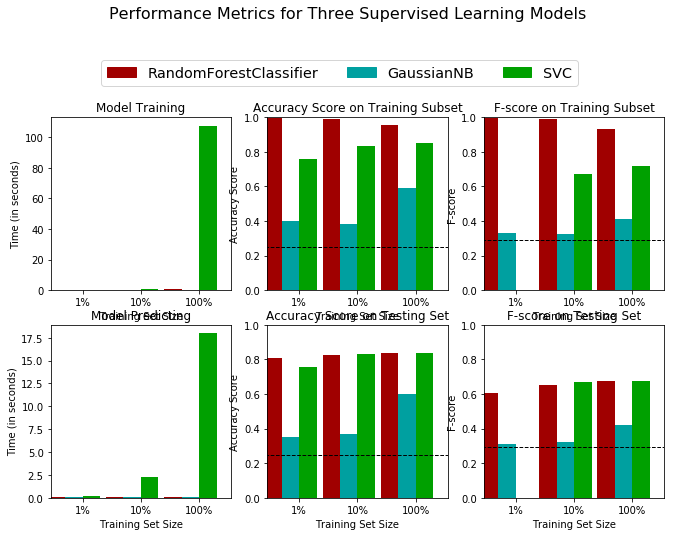

In [15]:
vs.evaluate(results, accuracy, fscore)

In [16]:
results

{'RandomForestClassifier': {0: {'train_time': 0.01798272132873535,
   'pred_time': 0.03591442108154297,
   'acc_train': 0.9933333333333333,
   'acc_test': 0.8100608070757325,
   'f_train': 0.9943181818181817,
   'f_test': 0.6070590863397743},
  1: {'train_time': 0.0633847713470459,
   'pred_time': 0.04341721534729004,
   'acc_train': 0.99,
   'acc_test': 0.82808181315644,
   'f_train': 0.9913793103448275,
   'f_test': 0.651497263067511},
  2: {'train_time': 0.7201602458953857,
   'pred_time': 0.04343867301940918,
   'acc_train': 0.9566666666666667,
   'acc_test': 0.8388059701492537,
   'f_train': 0.9337349397590362,
   'f_test': 0.6744068652195861}},
 'GaussianNB': {0: {'train_time': 0.002495288848876953,
   'pred_time': 0.06388211250305176,
   'acc_train': 0.4,
   'acc_test': 0.3517965726920951,
   'f_train': 0.3333333333333333,
   'f_test': 0.3101343466682625},
  1: {'train_time': 0.015972375869750977,
   'pred_time': 0.06238222122192383,
   'acc_train': 0.38333333333333336,
   'acc_

----
## Improving Results
In this final section, I will choose from the three supervised learning models the *best* model to use on the student data. <br>
I will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model


#### Random Forest Classifier.

##### (For all the results mentioned, it is agiven that the test set is considering with 100 percent of data used)

Of the results achived from our initial score, the choice had to be either between the Random Forest Classifier and the SVC particularly because both of them performed well with regards to F-Score aswell as accuracy on the test dataset. 

While there a minute(and neglible) difference in their scores for accuracy and F-measure, Random Forest Classifier emerged as a clear winner since the time it took for training and testing was extremly quick(by a huge margin) than that of the SVC. Its computational cost is very low. 

Random Forest Classifier also traditionally performs well on classification tasks such as this. 

In [17]:
# results

### Describing the Model in Layman's Terms

<hr>

The Random Forest classifier is like a collection of numerious Decision trees bundled together so that a collective higher accuracy and F-Score is achieved. 

A decision tree is like that of a typical Yes/No classification graph. Where the individual decides on a set of rules in order to classify data or predict outcomes. For example if Charity ML wants to decide what day is best suited for them to host a fundraiser given the dates of the entire year. They can start by a general rules of 
1. Those days which are holidays and which are not;
The tree can further be iterativly divided into Yes/No branches to find the optimal result. The further branches can be:
2. Of the days which are holidays, how many of them are family holidays(christmas, easter, Eid) so that maximum people can come.
3. Of these family holidays, how many of them fall at the beginning of the fiscal year? 
And it can iteratively go on and on untill the optimal result is achieved. 

These decisions can applied in many ways and combinations therefore many different "trees" can be formed. So a collection of these "trees" are known as a Random Forest and a combination of them allow us to achieving a higher accuracy and F-Score. 

The decsion tree is also very self explainatory where the rules can easily be understood without technical knowledge, it is also very intuitive and works well on classificaiton tasks like that of Charity ML. The best part of using a combination of decision trees is that it wouldn't overfit, meaning that the this learner won't "memorize" your data rather it would intuitively learn from them. 

https://medium.com/@Synced/how-random-forest-algorithm-works-in-machine-learning-3c0fe15b6674


### Implementation: Model Tuning
Fine tune the chosen model. I have used grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. I will  use the entire training set for this.

In [18]:
from sklearn import svm, grid_search, datasets
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score


clf = RandomForestClassifier(random_state=True)

# Create the parameters list to tune using a dictionary
parameters = {'n_estimators':[3,6,10,13], 'max_depth':[10,60, 64, 75, 85],  'min_samples_split':[2, 50, 60, 70]}

# Make an fbeta_score scoring object using make_scorer()
scorer =  make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\maazh\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8388
F-score on testing data: 0.6744

Optimized Model
------
Final accuracy score on the testing data: 0.8589
Final F-score on the testing data: 0.7257


In [19]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=70,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=1,
            oob_score=False, random_state=True, verbose=0,
            warm_start=False)

### Final Model Evaluation

Questions to consider
* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from the optimized model compare to the naive predictor benchmarks found earlier ?  

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8388     |     0.8589     |
| F-score        |      0.6744     |     0.7257     |


The scores achieved by the optimized model are better than the unoptimized model. 

While there is little change in the accuracy score between the unoptimized model and optimized model, we however see a significant improvement in F-Score in the model

The results of the Naive Predictor were:
Accuracy score: 0.2478;
F-score: 0.2917

We can see a significant improvement in the results between the naive predictor to our optimized model. We have achieved an accuracy of over 85% and a F-Score greater than 70% which is a reasonable amount. 

----
## Feature Importance

DeterminE which features provide the most predictive power. I will try to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.


### Feature Relevance Observation

The 5 features that are believe are most important for prediction are as follows, with the most important listed first and so on. 

1. Occupation:
An indivdual with a more senior/high-level/professional qualificaiton is most likely to have a > 50k with the likelihood decreasing with a much less important qualification

2. Education Level:
Individals with the tertiary level education are more likely to succeed than individuals with a lower level education therby having a greater income.

3. Age:
The age bracket of 35-50 is when the individual is more likely to rise in the corporate level and have a stable job thereby having a greater pay grade.

4. Sex:
Males dominate the industry and workforce. They have an advantage over females(though this is rapidly changing). This privilage enables them to have a better pay.

5. Marital Status:
Individuals who are married are likely to have a greater income and savings with a stable job compared to individuals who are single. 


### Implementation - Extracting Feature Importance

In the code cell below, I will implement the following:
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

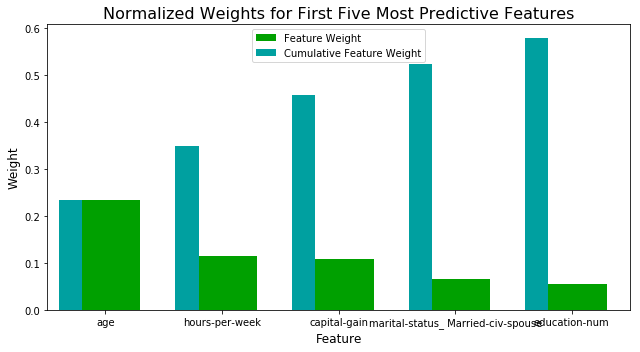

In [20]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

Marital Status, education and age are the features which are shown to be important and were discussed earlier. 

I was not significantly close to the anwser and though the visualization makes sense, it doesn't confirm the inital thoughts I had. 

This is perhaps due to strong cultural, social and economic difference between the country and region I am from(Pakistan, South Asia) to the region where this data has been taken from (USA, North America).

The features shown(and are those not discussed/mentioned by me earlier) are 
1. Hours per week
This makes sense as there is a strong correlation between the number of hours a person works and the pay he recieves. The greater the hours, the greater the gain. 

2. Capital gain
Investments are likely to yeild profit and increase income with time therby this feature too makes sense as it has a strong correlation with income

### Feature Selection

I will test how a model performs if I only use a subset of all the available features in the data. <br> 

With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. <br> From the visualization above, I see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that I can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model I found earlier, and train it on the same training set *with only the top five important features*. 

In [21]:
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8589
F-score on testing data: 0.7257

Final Model trained on reduced data
------
Accuracy on testing data: 0.8454
F-score on testing data: 0.6949


### Effects of Feature Selection

There is a significant impact on the models F-Score with the decrease in features. A slight decrease in accuracy is also noted. 

<b> I would not consider reducing the data to only 5 features if training time was a factor. </b> I would rather consider reducing the 3 least important features only if there is a significant need to reduce data due to training time. 

I however do not believe this would be neccassry as a Random Forest Classifer is an extremly fast classfier which rapidly learns and predicts outcomes faster than other classifiers such as GuassianNBs and Support Vector Classifiers.

In [1]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 465056 bytes to finding_donors.html']